### Importing Python libraries

In [83]:
# Importing necessary libraries 
import time 
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import boto3
import botocore
import sagemaker
from sagemaker import get_execution_role
from boto3 import client
import os 
from numpy import array
from numpy import argmax
from sklearn import preprocessing
from sklearn.preprocessing import MultiLabelBinarizer
import re

### Setting AWS Parameters

In [84]:
# Pointing to default bucket
sagemaker_session = sagemaker.Session()
bucket = sagemaker.Session().default_bucket()
prefix = 'sagemaker/aws-recommender-system'
dataset_location = prefix
execution_role = sagemaker.get_execution_role()
region=boto3.Session().region_name

# Returning S3 bucket values 
print(f"S3 Bucket: {bucket}", f"Prefix: {prefix}", f"Dataset location: {dataset_location}", f"Execution Role: {execution_role}", f"Region: {region}", 
      sep="\n")

S3 Bucket: sagemaker-us-east-1-981537519177
Prefix: sagemaker/aws-recommender-system
Dataset location: sagemaker/aws-recommender-system
Execution Role: arn:aws:iam::981537519177:role/service-role/AmazonSageMaker-ExecutionRole-20210707T184971
Region: us-east-1


### Creating class for obtaining data from S3 bucket 

In [91]:
class obtain_data:
    bucket = ''
    prefix = ''
    dataset_location = ''
    file_names = ''
    
    # Create constructor 
    def __init__(self, bucket, prefix, dataset_location):
        self.bucket = bucket
        self.prefix = prefix
        self.dataset_location = dataset_location

    # Check bucket permissions 
    def check_bucket_permissions(self):
        permission = False 
        # Checks if a given s3 bucket exists with the bucket specified 
        try:
            boto3.Session().client('s3').head_bucket(Bucket=self.bucket)
        except botocore.exceptions.ParamValidationError as e:
            print(f"s3 bucket: {self.bucket} does not exist or was not provided.")
        except botocore.exceptions.ClientError as e:
            if e.response['Error']['Code'] == "403":
                print(f"User does not have access to bucket: {bucket}")
            elif e.response['Error']['Code'] == "404":
                print(f"Bucket: {self.bucket} does not exist")
            else:
                raise
        # If no exceptions were raised then indicate that S3 bucket exists and user has access
        else:
            permission = True 
            print(f"Permission for S3: {self.bucket} is {permission}")
        return permission
    
    # Function to return list of files from S3
    def list_files_from_s3(self):
        conn = client('s3') 
        file_list = []
        for key in conn.list_objects(Bucket=self.bucket, Prefix=self.prefix)['Contents']:
            file_name = key['Key'].partition(f"{prefix}/")
            if len(file_name[2]) > 0: 
                file_list.append(file_name[2])
        return file_list
    
    # Function to download files from s3
    def download_from_s3(self):
        # Obtaining file list 
        file_list = self.list_files_from_s3()
        print(f"Files located in {self.prefix} is: {file_list}")
        s3 = boto3.resource('s3')
        for fn in file_list:
            file = f"{self.dataset_location}/{fn}"
            file_name = str(fn)
            try:
                s3.Bucket(bucket).download_file(file, str(file_name))
            except botocore.exceptions.ClientError as e:
                if e.response['Error']['Code'] == "404":
                    print(f"Object {file} does not exist.")
                else:
                    raise
            print(f"{fn} successfully downloaded")        

### Downloading files from S3

In [92]:
# Creating object of the class
obtain_data = obtain_data(bucket, prefix, dataset_location)

# Checking bucket permissions 
obtain_data.check_bucket_permissions()

# Listing files from S3 bucket 
obtain_data.list_files_from_s3()

# Downloading from S3
obtain_data.download_from_s3()

Permission for S3: sagemaker-us-east-1-981537519177 is True
Files located in sagemaker/aws-recommender-system is: ['links.csv', 'movies.csv', 'ratings.csv', 'tags.csv']
links.csv successfully downloaded
movies.csv successfully downloaded
ratings.csv successfully downloaded
tags.csv successfully downloaded


### Building Merged Dataset

In [257]:
# Obtaining ratings
ratings = pd.read_csv('ratings.csv')

# Obtaining movies 
movies = pd.read_csv('movies.csv')

# Obtaining tags 
tags = pd.read_csv('tags.csv')

# Obtaining links 
links = pd.read_csv('links.csv')

# Merging based on movieId
movie_ratings = pd.merge(movies, ratings, on='movieId')

# Merging tags dataset 
merged_ratings_tags = pd.merge(movie_ratings, tags, how ='outer', on=['movieId','userId'])


In [97]:
# Checking number of rows with empty title
if len(merged_ratings_tags.loc[merged_ratings_tags.title.isnull(), 'title']) > 0:
        
        # Placing missing titles and genres based on movieId 
        movies.set_index(movies.movieId)
        merged_ratings_tags.loc[merged_ratings_tags.title.isnull(), 'title'] = merged_ratings_tags['movieId'].map(movies.title)
        
        # Placing missing titles and genres based on movieId 
        merged_ratings_tags.loc[merged_ratings_tags.genres.isnull(), 'genres'] = merged_ratings_tags['movieId'].map(movies.genres)
        
        # Dropping unneccessary columns 
        merged_ratings_tags.drop(['timestamp_x', 'timestamp_y'], axis = 1, inplace=True)
        
# Checking number of missing titles 
len(merged_ratings_tags[merged_ratings_tags['genres'].isna()])

# Removing rows where the genres and titles rows are missing 
merged_ratings_tags = merged_ratings_tags[merged_ratings_tags['genres'].notna()]
merged_ratings_tags

,movieId,title,genres,userId,rating,tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,NaN
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,NaN
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,NaN
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,NaN
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,NaN
...,...,...,...,...,...,...
102879,6016,Kiss Kiss Bang Bang (2005),Comedy|Crime|Mystery|Thriller,573,NaN,not seen
102880,6157,Aquamarine (2006),Children|Comedy|Fantasy,573,NaN,bad
102881,6157,Aquamarine (2006),Children|Comedy|Fantasy,573,NaN,Ben Affleck
102882,273,"Secret of Roan Inish, The (1994)",Children|Drama|Fantasy|Mystery,600,NaN,gothic


### Applying One Hot Encoding

In [98]:
# Creating an array value for each genres value 
merged_ratings_tags['genres_array'] = merged_ratings_tags['genres'].str.split('|')    

In [99]:
# One Hot Encoding the genres
from sklearn.preprocessing import MultiLabelBinarizer

genre_list = pd.Series(merged_ratings_tags['genres_array'])
mlb = MultiLabelBinarizer()
mlb.fit_transform(genre_list)
one_hot_genres = pd.DataFrame(mlb.fit_transform(genre_list),columns=mlb.classes_,index=genre_list.index)

# Building master dataset 
master_data = pd.merge(merged_ratings_tags, one_hot_genres, left_index=True, right_index=True)
master_data.drop(['genres', 'genres_array'], axis = 1, inplace=True)
master_data

,movieId,title,userId,rating,tag,(no genres listed),Action,Adventure,Animation,Children,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),1,4.0,NaN,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,Toy Story (1995),5,4.0,NaN,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,Toy Story (1995),7,4.5,NaN,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,Toy Story (1995),15,2.5,NaN,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,Toy Story (1995),17,4.5,NaN,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102879,6016,Kiss Kiss Bang Bang (2005),573,NaN,not seen,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
102880,6157,Aquamarine (2006),573,NaN,bad,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
102881,6157,Aquamarine (2006),573,NaN,Ben Affleck,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
102882,273,"Secret of Roan Inish, The (1994)",600,NaN,gothic,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [100]:
# Saving master dataset to local environment 
master_data.to_csv('master_data.csv')

### Data Exploration

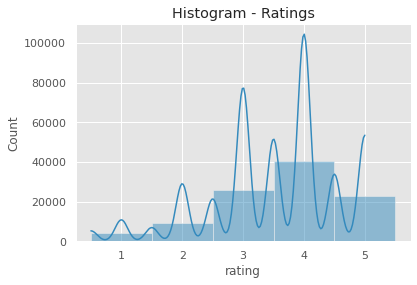

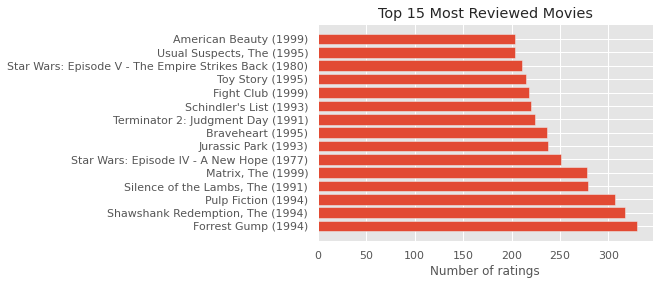

In [205]:
import seaborn as sns 

# Setting default seaborn visualization 
sns.set()
sns.set_style('darkgrid')
plt.style.use('ggplot')


# Histogram - Ratings 
hist = sns.histplot(master_data, x='rating', binwidth=1, kde=True).set(title='Histogram - Ratings')

# Top N movies 
def top_n_most_reviewed(df, n, gb):
    plt.figure()
    most_rated = df.groupby(gb).size().reset_index(name='Count').sort_values(['Count'], ascending=False).head(n)
    plt.barh(most_rated[gb], most_rated['Count'])
    plt.xlabel('Number of ratings')
    plt.title(f"Top {n} Most Reviewed Movies")
    plt.show()

        
top_n_most_reviewed(movie_ratings, 15, 'title')

#display(hist)

In [288]:
# Splitting the movie field into a movie_title and movie_year column
movie_title = []
movie_year = []
    
for i in movie_ratings.title:
    movie_split = re.match(r'^(.*) \((19\d\d|20\d\d)\)$', i)
    if movie_split is None:
        movie_title.append("")
        movie_year.append("")
    else:
        movie_title.append(movie_split.groups()[0])
        movie_year.append(movie_split.groups()[1])
        
movie_ratings['movie_title'] = movie_title
movie_ratings['movie_year'] = movie_year

movie_ratings.head()

,movieId,title,genres,userId,rating,timestamp,movie_title,movie_year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,Toy Story,1995
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,Toy Story,1995
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946,Toy Story,1995
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970,Toy Story,1995
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483,Toy Story,1995


In [223]:
movie_ratings_year = movie_ratings

movie_ratings_year[['Movie', 'Year']] = movie_ratings['title'].str.split('(', 1, expand=True)
movie_ratings_year

,movieId,title,genres,userId,rating,timestamp,Movie,Year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,Toy Story,1995)
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,Toy Story,1995)
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946,Toy Story,1995)
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970,Toy Story,1995)
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483,Toy Story,1995)
...,...,...,...,...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184,4.0,1537109082,Black Butler: Book of the Atlantic,2017)
100832,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184,3.5,1537109545,No Game No Life: Zero,2017)
100833,193585,Flint (2017),Drama,184,3.5,1537109805,Flint,2017)
100834,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184,3.5,1537110021,Bungo Stray Dogs: Dead Apple,2018)


### Importing Functions 

In [5]:
# Function borrowed from AWS sample notebook with some modifications to the print outputs 
def check_bucket_permissions(bucket):
    permission = False 
    # Checks if a given s3 bucket exists with the bucket specified 
    try:
        boto3.Session().client('s3').head_bucket(Bucket=bucket)
    except botocore.exceptions.ParamValidationError as e:
        print(f"s3 bucket: {bucket} does not exist or was not provided.")
    except botocore.exceptions.ClientError as e:
        if e.response['Error']['Code'] == "403":
            print(f"User does not have access to bucket: {bucket}")
        elif e.response['Error']['Code'] == "404":
            print(f"Bucket: {bucket} does not exist")
        else:
            raise
    # If no exceptions were raised then indicate that S3 bucket exists and user has access
    else:
        permission = True 
    return permission

# Function to return list of files from S3
def list_files_from_s3(bucket, prefix):
    conn = client('s3') 
    file_list = []
    for key in conn.list_objects(Bucket=bucket, Prefix=prefix)['Contents']:
        file_name = key['Key'].partition(f"{prefix}/")
        if len(file_name[2]) > 0: 
            file_list.append(file_name[2])
    return file_list

# Function to download files from s3
def download_from_s3(bucket, dataset_location, file_names):
    s3 = boto3.resource('s3')
    for fn in file_names:
        file = f"{dataset_location}/{fn}"
        file_name = str(fn)
        try:
            s3.Bucket(bucket).download_file(file, str(file_name))
        except botocore.exceptions.ClientError as e:
            if e.response['Error']['Code'] == "404":
                print(f"Object {file} does not exist.")
            else:
                raise

### Downloading files 

In [7]:
# Checking bucket permissions 
check_bucket_permissions(bucket)

# Obtain list of files from s3 bucket 
file_list = list_files_from_s3(bucket, prefix)

# Dowloading data from S3 bucket to local notebook environment 
dataset_location = prefix
download_from_s3(bucket, dataset_location, file_list)